In [82]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

from helper import AR_generator, manual_ar_process, adf_test, yule_walker, calculate_unit_roots \
    , plot_roots


# Data manually generated

In [ ]:
ar_coeffs = [0.6, 0.35] 

manual_data = manual_ar_process(ar_coeffs, 2, 1000)

train_data, test_data = train_test_split(manual_data, test_size=0.01, shuffle=False)

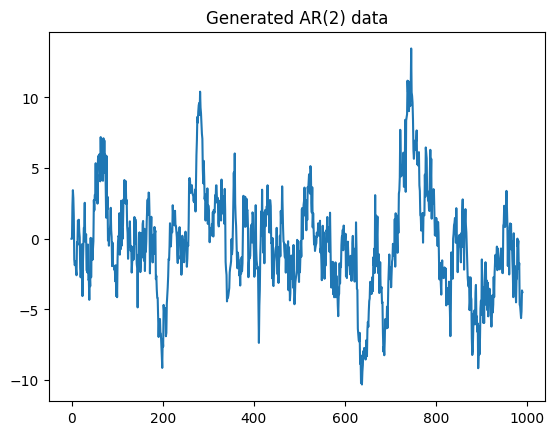

In [11]:
plt.title("Generated AR(2) data")
plt.plot(train_data)
plt.savefig("images/plots_application/ar2_data.png")

## Stationarity

In [7]:
adf_test(train_data)

Results of Dickey-Fuller Test:
Test Statistic                  -4.592287
p-value                          0.000133
#Lags Used                       1.000000
Number of Observations Used    988.000000
Critical Value (1%)             -3.436986
Critical Value (5%)             -2.864470
Critical Value (10%)            -2.568330
dtype: float64


In [13]:
# Calculate roots and unit roots
roots, unit_roots = calculate_unit_roots(ar_coeffs)

# Check for stationarity: All roots should lie outside the unit circle
is_stationary = all(abs(root) > 1 for root in unit_roots)
if is_stationary:
    print("The process is stationary")


The process is stationary


In [14]:
unit_roots

array([ 1.03807131, -2.75235702])

In [29]:
# function here to save the picture, return fig
def plot_roots(unit_roots, padding=1):
    fig = plt.figure(figsize=(6, 6))
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linewidth=0.8, linestyle='--')
    ax = plt.gca()
    ax.add_artist(circle)
    ax.scatter(unit_roots.real, unit_roots.imag, color='red', label='Unit Roots')
    ax.set_xlabel("Re")
    ax.set_ylabel("Im")
    ax.set_title("Unit Roots of the Lag Polynomial")
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.grid()
    
    # Autoscale and add padding
    ax.autoscale()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim([xlim[0] - padding, xlim[1] + padding])
    ax.set_ylim([ylim[0] - padding, ylim[1] + padding])
    
    return fig

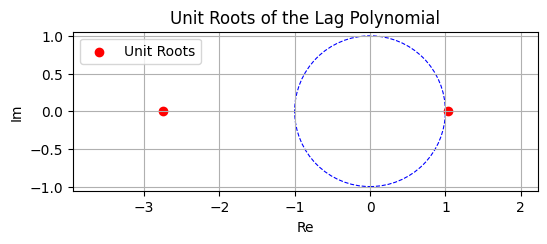

In [30]:
image = plot_roots(unit_roots)
image.savefig("images/plots_application/ar2_roots.png")



## Plot ACF and PACF

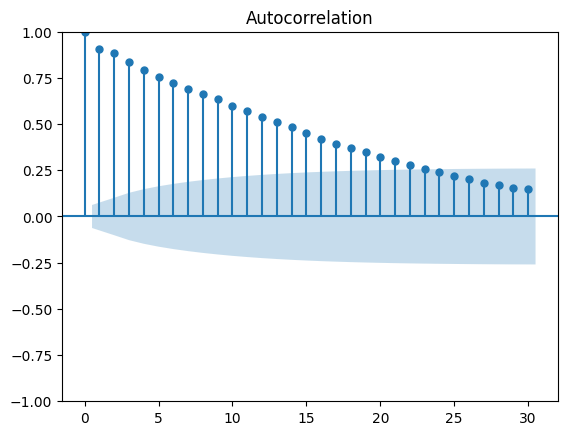

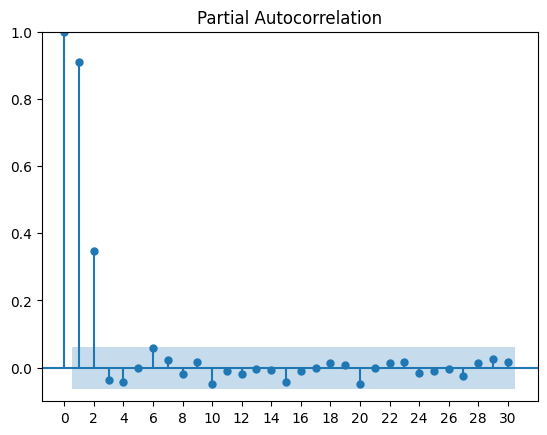

In [53]:
fig1 = plot_acf(train_data, lags=30)
#plt.title("ACF")
plt.show()
fig1.savefig("images/plots_application/ar2_acf.png")

fig = plot_pacf(train_data, lags=30)
#plt.title("PACF")
plt.xticks(np.arange(0, 31, 2))
plt.ylim(-0.1, 1)
plt.show()
fig.savefig("images/plots_application/ar2_acf_pacf.png")


## Train models

In [68]:
aic_values = np.array([])
for k in range(1, 20):
    model_k = ARIMA(train_data, order=(k, 0, 0)).fit()
    aic_values = np.append(aic_values, model_k.aic)



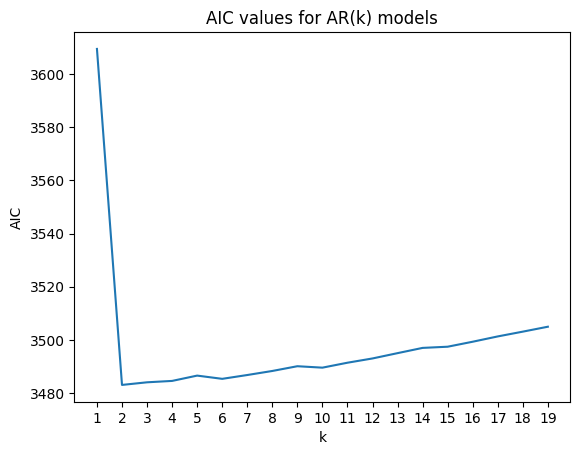

In [70]:
plt.plot(np.arange(1, 20), aic_values)
plt.xticks(np.arange(1, 20))
plt.title("AIC values for AR(k) models")
plt.xlabel("k")
plt.ylabel("AIC")
plt.savefig("images/plots_application/values_aic.png")

## Check residuals

In [73]:
model = ARIMA(train_data, order=(2, 0, 0)).fit()

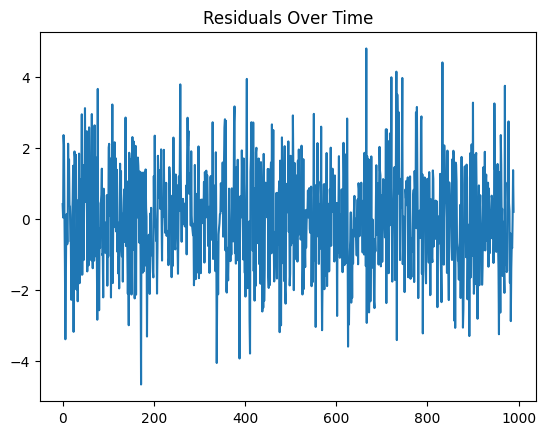

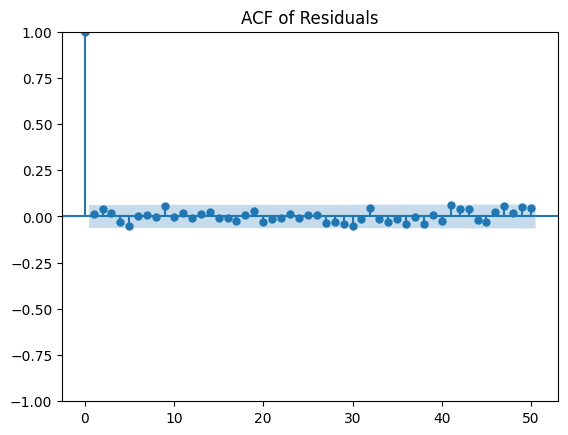

In [74]:
residuals = model.resid
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.show()

plot_acf(residuals, lags=50)
plt.title("ACF of Residuals")
plt.show()

## Compare paramters

In [84]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  990
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1737.537
Date:                Fri, 03 Jan 2025   AIC                           3483.074
Time:                        15:35:21   BIC                           3502.665
Sample:                             0   HQIC                          3490.524
                                - 990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4143      0.748     -0.554      0.580      -1.881       1.052
ar.L1          0.5917      0.027     21.575      0.000       0.538       0.645
ar.L2          0.3486      0.027     12.692      0.000       0.295       0.402
sigma2         1.9548      0.085     22.915      0.000       1.788       2.122
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.93
Prob(Q):                              0.71   Prob(JB):                         0.38
Heteroskedasticity (H):               1.23   Skew:                             0.09
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Forecasted Values: [-3.53820644 -3.43731431 -3.29196613 -3.17079512 -3.04843166 -2.93379094
 -2.82330391 -2.71796671 -2.61712455 -2.52073728]


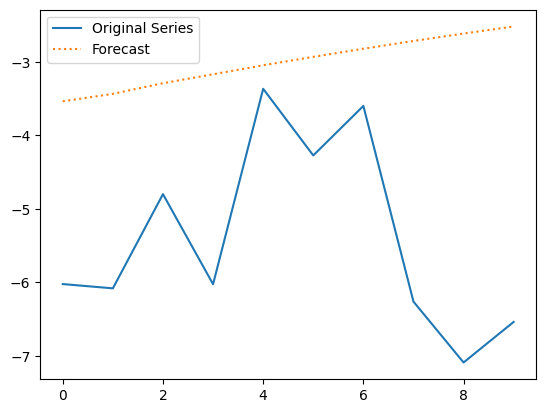

In [ ]:
forecast = model.get_forecast(steps=10)
forecast_values = forecast.predicted_mean
print("Forecasted Values:", forecast_values)

# Plot
plt.plot(test_data, label="Original Series")
plt.plot(forecast_values, label="Forecast", linestyle="dotted")
plt.legend()
plt.savefig("images/plots_application/statsmodels_forecast.png")
plt.show()

## Forecast with the estimated parameters from Yule Walker

In [85]:
estimators, est_var = yule_walker(train_data, 2)

In [87]:
print(estimators, est_var)

[0.5918511  0.35012251] 1.9241859718672671


In [88]:
yulewlaker_test = train_data[988:]
estimated_noise = np.random.normal(0, np.sqrt(est_var), 10)
new_predicted = np.zeros(10)
new_predicted[:2] = yulewlaker_test[:2]

for k in range(2,10):
    new_predicted[k] = sum(estimators[i] * new_predicted[k-i-1] for i in range(2)) + estimated_noise[k]

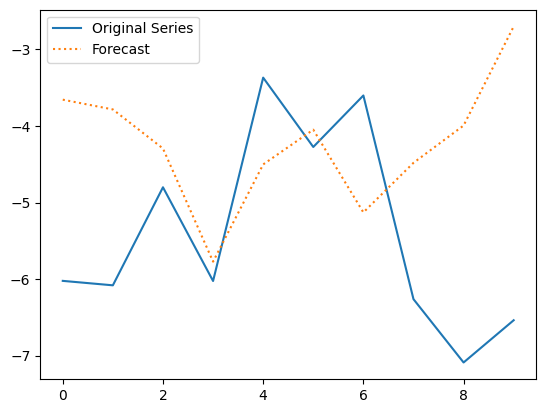

In [92]:
plt.plot(test_data, label="Original Series")
plt.plot(new_predicted, label="Forecast", linestyle="dotted")
plt.legend()
plt.savefig("images/plots_application/yule_walker_forecast.png")
plt.show()